# **Introduction to Word Embeddings**

This tutorial illustrates several applications of word embeddings by estimating a Word2Vec model using an off-the-shelf python library (```Gensim```).

Some additional resources on Word2Vec:
- [Jurafsky & Martin (2021). Book chapter.](https://web.stanford.edu/~jurafsky/slp3/6.pdf)
- [Mikolov et al. (2013). Original paper.](https://arxiv.org/pdf/1301.3781.pdf)
- [Rong (2016). Additional explanation on how to train the model.](https://arxiv.org/pdf/1411.2738.pdf)
- [Alammar (2019). Illustrated guide.](https://jalammar.github.io/illustrated-word2vec/)
- [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)

## **Setup**

In [3]:
# ## install necessary packages
# !pip install flashtext                  # easy phrase replacing methods
# !pip install contractions               # expand English contractions 
# !pip install --upgrade spacy==2.2.4     # functions for lemmatizing
# !pip install gensim==4.0.0              # word2vec estimation
# !pip install adjustText                 # generate plots with lots of text labels

In [4]:
import sys
import pandas as pd
import numpy as np
import string
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [5]:
# define paths
data_path = "../data/"
pymodules_path = "../pymodules"

In [6]:
# import our own code
sys.path.append(pymodules_path)
import preprocessing_class as pc
import dictionary_methods as dictionary_methods

## **Off-the-shelf Word2Vec using Gensim**

[Gensim](https://radimrehurek.com/gensim/index.html) is a very powerful library that contains efficient (written in ```C```) implementations of several NLP models. Word2Vec is included among these. We will start by using this library to demonstrate use cases for word embeddings.

### *Load data and preprocess text*

We will now load some real data over which we will estimate our word embeddings. We see that our data consists of paragraphs from the Inflation Reports produced by the Bank of England. The data starts on 1998 and ends in 2015. Reports are produced four times a year in the months of February, May, August and November.

As a starting point, we will need to download three data files from Google Drive:
1. [Inflation Reports data](https://drive.google.com/file/d/1o_67kmSkLjaEoYxIUkfnouC_Nm_IQJZE/view?usp=sharing) 
2. [Monetary Policy Committee minutes data](https://drive.google.com/file/d/1iCtirTJfgowx2TVJVmISNRbq690wv1vm/view?usp=sharing)
3. [Quarterly GDP data](https://drive.google.com/file/d/1m9lTsJU2--K8mpLu2STZSS691WLZnN6h/view?usp=sharing)

Once you download the two files put them in the *"data"* folder and keep their original names.

In [26]:
data = pd.read_csv(data_path + "ir_data_final.txt", sep="\t")
data = data[['ir_date', 'paragraph']]
data.columns = ['yearmonth', 'paragraph']
print(data.shape)
data.head(10)

(15023, 2)


,yearmonth,paragraph
0,199802,It is almost six years since output reached it...
1,199802,Monetary policy is currently being pulled in o...
2,199802,"On the other hand, the delayed demand effect o..."
3,199802,"The scale of the slowdown depends, in part, on..."
4,199802,"Net trade is weakening, but domestic demand gr..."
5,199802,The combination of sharply weakening net trade...
6,199802,The MPC’s probability distribution for the fou...
7,199802,The MPC’s projection of the twelve-month RPIX ...
8,199802,"Overall, the balance of risks to inflation in ..."
9,199802,"Against the background of this projection, the..."


In [25]:
# explore one of the paragraphs
data.loc[0, "paragraph"]

'It is almost six years since output reached its trough in the last recession. Since then, output has risen at an average rate of 3% a year and inflation has fallen from almost 5% to below 3% a year. The combination of above-trend growth and falling inflation is unsustainable, and has probably already come to an end. At this juncture, with output growth likely to fall sharply, monetary policy is more finely balanced than at any point since the inflation target was introduced in 1992. The central issue is whether the existing policy stance will slow the economy sufficiently quickly to prevent further upward pressure on earnings growth and retail price inflation.'

In [27]:
# check how often these reports are produced
grouped = data.groupby("yearmonth", as_index=False).size()
print(grouped.head(5))
print()
print(grouped.tail(5))

   yearmonth  size
0     199802   177
1     199805   161
2     199808   195
3     199811   176
4     199902   191

    yearmonth  size
65     201405   235
66     201408   229
67     201411   220
68     201502   214
69     201505   214


In [28]:
def apply_preprocessing(data, replacing_dict, pattern, punctuation):
    """ Function to apply the steps from the preprocessing class in the correct
        order to generate a term frequency matrix and the appropriate dictionaries
    """
    
    prep = pc.RawDocs(data, stopwords="short", lower_case=True, contraction_split=True, tokenization_pattern=pattern)
    prep.phrase_replace(replace_dict=replacing_dict, case_sensitive_replacing=False)
    # lower-case text, expand contractions and initialize stopwords list
    prep.basic_cleaning()
    # split the documents into tokens
    prep.tokenize_text()
    # clean tokens
    prep.token_clean(length=2, punctuation=punctuation, numbers=True)
    # create document-term matrix
    prep.dt_matrix_create(items='tokens', min_df=10, score_type='df')
    
    # get the vocabulary and the appropriate dictionaries to map from indices to words
    word2idx = prep.vocabulary["tokens"]
    idx2word = {i:word for word,i in word2idx.items()}
    vocab = list(word2idx.keys())
    
    return prep, word2idx, idx2word, vocab

In [29]:
# define dictionary for pre-processing class with terms we want to preserve
replacing_dict = {'monetary policy':'monetary-policy',
                  'interest rate':'interest-rate',
                  'interest rates':'interest-rate',
                  'yield curve':'yield-curve',
                  'repo rate':'repo-rate',
                  'bond yields':'bond-yields',
                  'real estate':'real-estate',
                  'economic growth':'economic-growth'}

In [30]:
# define tokenization pattern and punctuation symbols
pattern = r'''
          (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
          \w+(?:-\w+)*        # word characters with internal hyphens
          | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
          '''
punctuation = string.punctuation.replace("-", "")

In [31]:
# use preprocessing class
prep, word2idx, idx2word, vocab = apply_preprocessing(data.paragraph, replacing_dict, pattern, punctuation)

In [32]:
# inspect a particular tokenized document and compare to its original form
i = 10
print(data.paragraph[i])
print("\n ------------------------------- \n")
print(prep.tokens[i])

Broad money continues to grow at double-digit rates (see Chart 1.1). But there are signs that the pace of growth has moderated since the first half of 1997. The slowdown in money growth was preceded by a slowdown in lending, particularly to the corporate sector. Official interest rates have been unchanged since the rise in the Bank’s repo rate on 6 November to 7.25%. Long-term nominal interest rates have fallen by around 50 basis points in the United Kingdom and by around 40 basis points overseas during the same period. The starting-point for the nominal effective exchange rate in the inflation projection, based on its average value in the 15 working days to 4 February, was 104.9—around 2.8% higher than the starting-point used in the November Report.

 ------------------------------- 

['broad', 'money', 'continues', 'grow', 'rates', 'see', 'chart', 'but', 'there', 'are', 'signs', 'that', 'the', 'pace', 'growth', 'has', 'moderated', 'since', 'the', 'first', 'half', 'the', 'slowdown', '

### *Model estimation*

Now that we have our text preprocessed we can use the [Gensim](https://radimrehurek.com/gensim/) library to efficiently estimate word embeddings using word2vec.

In [33]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=5,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=1,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                       )

In [34]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(3579, 100)

There a lot of different ways in which we can use these estimated word embeddings. We will start by showing a simple way to visualize them in 2-dimensions.

### *Visualization*

In [38]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))
    
    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

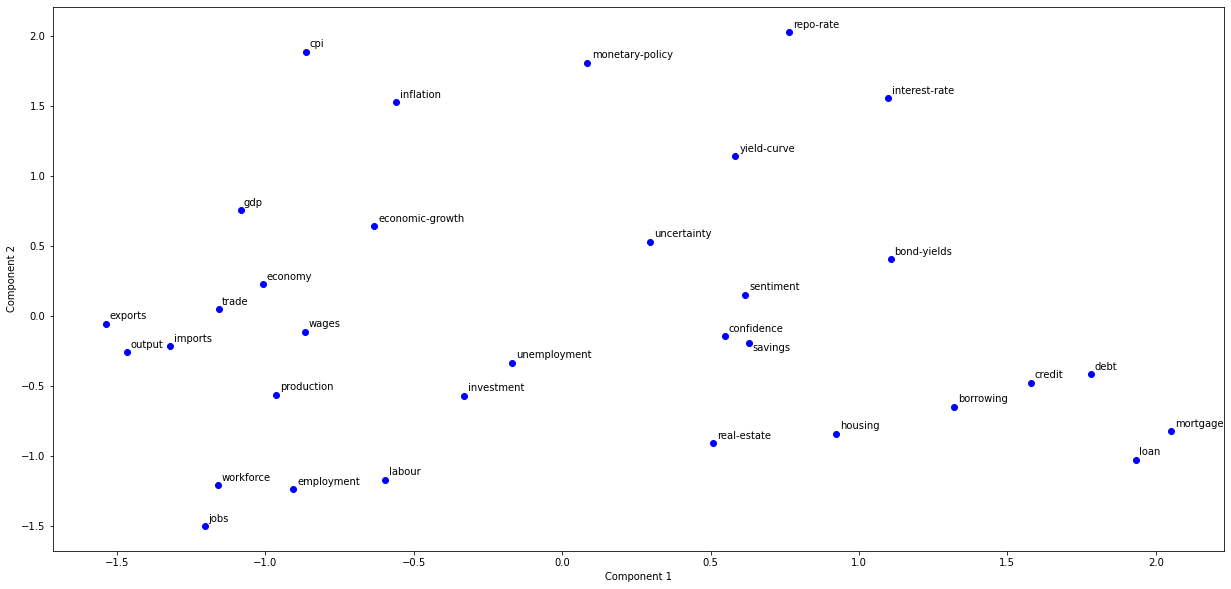

In [39]:
# define the tokens to use in the plot
tokens_of_interest = ['economy', 'gdp', 'production', 'output',
                      'investment', 'confidence', 'sentiment',
                      'uncertainty', 'inflation', 'cpi',
                      'loan', 'mortgage', 'credit', 'debt', 'savings', 
                      'borrowing', 'housing', 'labour', 'workforce', 
                      'unemployment', 'employment', 'jobs', 'wages',
                      'trade', 'exports', 'imports']

# expand the list of tokens with all the tokens from the replacement dictionary
tokens_of_interest = set(tokens_of_interest + list(replacing_dict.values()) )

# plot
pca_scatterplot(word_vectors, list(tokens_of_interest))

We can clearly observe how words form some thematically cohesive groups; trade (e.g. exports, imports, trade, output), job-market (e.g. workforce, jobs, employment), housing (e.g. real-state, housing, borrowing, mortgage).

### *Nearest neighbors analysis*

We can further explore how words cluster in the embedded space by analyzing the nearest neighbours of some selected words.

In [40]:
# find the K nearest neighbours of relevant words
K = 10
words = ["uncertainty", "risk", "stable",
         "contraction", "expansion",
         "monetary-policy", "interest-rate", "inflation"]

for word in words:
    print(f"Nearest neighbors of: {word}")
    print(word_vectors.most_similar(word, topn=K))
    print("\n")

Nearest neighbors of: uncertainty
[('doubts', 0.6419909000396729), ('uncertainties', 0.6365733742713928), ('surrounding', 0.6188446879386902), ('fears', 0.61778724193573), ('surrounds', 0.6146233081817627), ('duration', 0.6106055974960327), ('concerns', 0.5991458296775818), ('depth', 0.5939427018165588), ('considerable', 0.5921647548675537), ('concern', 0.578204333782196)]


Nearest neighbors of: risk
[('possibility', 0.6882918477058411), ('downside', 0.6575586795806885), ('premium', 0.6569870114326477), ('upside', 0.6305557489395142), ('risks', 0.6201984882354736), ('pose', 0.6118707656860352), ('posing', 0.5984246730804443), ('threat', 0.5891011953353882), ('poses', 0.5762071013450623), ('reappraisal', 0.5737084746360779)]


Nearest neighbors of: stable
[('steady', 0.6979434490203857), ('remarkably', 0.6896635293960571), ('fairly', 0.683296799659729), ('flat', 0.6814144849777222), ('resilient', 0.6402592658996582), ('fluctuated', 0.624945878982544), ('benign', 0.6080789566040039), ('

### *Analogy tasks*

A very interesting, and surprising, use of word embeddings is to find word analogies. The famous example used by [Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf) searches for a word $X$ in the embedded space that is similar to "woman" in the same sense that "king" is similar to "man". This task can be expressed in terms of a simple vector arithmetic problem as follows:

$$
\vec{King}^{\,} - \vec{Man}^{\,} = \vec{X}^{\,} - \vec{Woman}^{\,} \\
\vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} = \vec{X}^{\,}
$$

Mikolov et al. (2013) find that when performing this operation on their trained embeddings, they are able to recover the word "queen".

$$ \vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} \approx \vec{Queen}^{\,} $$

Using ```Gensim``` this operation can be very easily perfomed by simply using the ```.most_similar()``` function as follows:

<center>

```python
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
```

</center>

We will play with this idea and try to extend it to our own domain. Some of the analogies that we will try to solve are: 

$$
\vec{Contraction}^{\,} - \vec{Expansion}^{\,} + \vec{Downward}^{\,} = \vec{X}^{\,} \\
\vec{Inflation}^{\,} - \vec{CPI}^{\,} + \vec{GDP}^{\,} = \vec{X}^{\,} \\
$$

In [41]:
# create the analogy tasks for our data
positive_words = [['contraction', 'downward'],
                  ['expansion', 'tighten'],
                  ['inflation', 'gdp'],
                  ['company', 'wages']]

negative_words = [['expansion'],
                  ['contraction'],
                  ['cpi'],
                  ['profits']]

for pw, nw in zip(positive_words, negative_words):
    print(f"Analogy task for positive words: {pw} and negative words {nw}")
    print(word_vectors.most_similar(positive=pw, negative=nw))
    print("\n")

Analogy task for positive words: ['contraction', 'downward'] and negative words ['expansion']
[('upward', 0.7148268222808838), ('upwards', 0.6246974468231201), ('downwards', 0.6236264705657959), ('lessening', 0.5131341814994812), ('movement', 0.5023254752159119), ('masked', 0.4965052306652069), ('revision', 0.4905395805835724), ('placing', 0.48904168605804443), ('exert', 0.48706313967704773), ('sizable', 0.48392224311828613)]


Analogy task for positive words: ['expansion', 'tighten'] and negative words ['contraction']
[('improve', 0.675494909286499), ('loosen', 0.647791862487793), ('expand', 0.5738944411277771), ('stimulative', 0.5534189343452454), ('backstop', 0.547343373298645), ('looser', 0.5409491062164307), ('functioning', 0.5408640503883362), ('tight', 0.5393858551979065), ('providing', 0.5336853861808777), ('credible', 0.526263415813446)]


Analogy task for positive words: ['inflation', 'gdp'] and negative words ['cpi']
[('uneven', 0.49301818013191223), ('four-quarter', 0.48344

### *Building dictionaries*

One last use of word embeddings is to expand existing dictionaries by finding the nearest neighbours to a set of "center" terms. To illustrate this, we will show how to generate dictionaries of positive and negative terms to analyze text data from the Bank of England Monetary Police Comittee minutes.

In [42]:
# create a positive dictionary by finding the nearest neighbors to a combination of relevant words
N = 40
pos_center_terms = ['expansion', 'stable']
pos_nn = [w for w, _ in word_vectors.most_similar(positive=pos_center_terms, topn=N)]
pos_word2vec = pos_center_terms + pos_nn
print(pos_word2vec)

['expansion', 'stable', 'steady', 'vigorous', 'brisk', 'resilient', 'remarkably', 'robust', 'fairly', 'buoyant', 'solid', 'solidly', 'robustly', 'upswing', 'bolstered', 'softness', 'slackened', 'above-trend', 'healthy', 'briskly', 'lacklustre', 'buoyancy', 'buoyed', 'stagnant', 'resumed', 'below-trend', 'reasonably', 'uneven', 'gather', 'revive', 'fluctuated', 'tandem', 'disappointed', 'odds', 'acceleration', 'strengthening', 'upturn', 'gently', 'firm', 'accelerated', 'characterised', 'supporting']


In [43]:
# create a negative dictionary by finding the nearest neighbors to a combination of relevant words
N = 40
neg_center_terms = ['contraction', 'uncertainty']
neg_nn = [w for w, _ in word_vectors.most_similar(positive=neg_center_terms, topn=N)]
neg_word2vec = neg_center_terms + neg_nn
print(neg_word2vec)

['contraction', 'uncertainty', 'destocking', 'softness', 'anxieties', 'deceleration', 'bounceback', 'upswing', 'worsening', 'exacerbated', 'sars', 'doubts', 'correction', 'gathers', 'momentum', 'slackening', 'conflict', 'pause', 'lacklustre', 'duration', 'sharper-than-expected', 'deteriorating', 'military', 'slowdown', 'patchy', 'moderation', 'hostilities', 'severity', 'gather', 'boom', 'amid', 'acceleration', 'uneven', 'retrenchment', 'softening', 'depth', 'outbreak', 'abrupt', 'half-year', 'turmoil', 'impairment', 'upturn']


In [44]:
# load data for dictionary method example
path_dict_example = data_path + 'mpc_minutes.txt'
data_dict, prep_dict = dictionary_methods.dict_example(path_dict_example) # dataframe, preprocessing object

In [45]:
# generate the count of positive and negative lemmas in the corpus with our new dictionaries
pos_counts_word2vec, neg_counts_word2vec = dictionary_methods.pos_neg_counts(prep_dict, pos_word2vec, neg_word2vec)

In [46]:
# Apel and Blix-Grimaldi (2012) dictionaries
pos_words_AB = ['accelerate','accelerated','accelerates','accelerating','expand','expanded','expanding','expands',
             'fast','faster','fastest','gain','gained','gaining','gains','high','higher','highest','increase',
             'increased','increases','increasing','strong','stronger','strongest']

neg_words_AB = ['contract','contracted','contracting','contracts','decelerate','decelerated','decelerates',
             'decelerating','decrease','decreased','decreases','decreasing','lose','losing','loss','losses',
             'lost','low','lower','lowest','slow','slower','slowest','weak','weaker','weakest']

In [47]:
# generate the count of positive and negative lemmas in the corpus with Apel and Blix-Grimaldi (2012)
pos_counts_AB, neg_counts_AB = dictionary_methods.pos_neg_counts(prep_dict, pos_words_AB, neg_words_AB)

In [48]:
# add counts to the data
data_dict['pos_counts_word2vec'] = pos_counts_word2vec
data_dict['neg_counts_word2vec'] = neg_counts_word2vec

data_dict['pos_counts_AB'] = pos_counts_AB
data_dict['neg_counts_AB'] = neg_counts_AB

data_dict.head()

,date,minutes,year,quarter,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB
0,199706,1 Sections I to V of this minute summarise t...,1997,2,0.0,0.0,0.0,0.0
1,199706,The 12-month growth rate of notes and coins ...,1997,2,0.0,1.0,0.0,0.0
2,199706,"Broad money, too, decelerated in April: its ...",1997,2,1.0,0.0,2.0,2.0
3,199706,Lending growth continued at around 9% in ...,1997,2,0.0,0.0,1.0,1.0
4,199706,Lending to individuals remained robust in...,1997,2,1.0,0.0,1.0,0.0


In [49]:
# aggregate to year-month level
data_agg = data_dict.groupby(['date']).agg({'pos_counts_word2vec': 'sum', 'neg_counts_word2vec': 'sum',
                                            'pos_counts_AB': 'sum', 'neg_counts_AB': 'sum',
                                            'year': 'mean', 'quarter':'mean'})
data_agg.head()

,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB,year,quarter
date,,,,,,
199706,10.0,11.0,27.0,16.0,1997.0,2.0
199707,9.0,5.0,83.0,25.0,1997.0,3.0
199708,12.0,15.0,76.0,21.0,1997.0,3.0
199709,17.0,18.0,70.0,30.0,1997.0,3.0
199710,19.0,11.0,94.0,38.0,1997.0,4.0


In [50]:
# aggregate to year-quarter level removing incomplete quarters 
data_agg['months_x_quarter'] = 1
data_agg = data_agg.groupby(['year', 'quarter']).sum()[['pos_counts_word2vec', 'neg_counts_word2vec',
                                                        'pos_counts_AB', 'neg_counts_AB',
                                                        'months_x_quarter']]

data_agg = data_agg[data_agg['months_x_quarter']==3]
del data_agg['months_x_quarter']

data_agg.head()

pos_counts_word2vec  neg_counts_word2vec  pos_counts_AB  \
year   quarter                                                            
1997.0 3.0                     38.0                 38.0          229.0   
       4.0                     64.0                 48.0          222.0   
1998.0 1.0                     75.0                 86.0          237.0   
       2.0                    116.0                 59.0          229.0   
       3.0                     85.0                 86.0          248.0   

                neg_counts_AB  
year   quarter                 
1997.0 3.0               76.0  
       4.0               99.0  
1998.0 1.0              143.0  
       2.0              168.0  
       3.0              175.0

In [51]:
# compute sentiment at year-quarter level
data_agg['sentiment_word2vec'] = (data_agg.pos_counts_word2vec - data_agg.neg_counts_word2vec)/(data_agg.pos_counts_word2vec + data_agg.neg_counts_word2vec)
data_agg['sentiment_AB'] = (data_agg.pos_counts_AB - data_agg.neg_counts_AB)/(data_agg.pos_counts_AB + data_agg.neg_counts_AB)
data_agg.head()

pos_counts_word2vec  neg_counts_word2vec  pos_counts_AB  \
year   quarter                                                            
1997.0 3.0                     38.0                 38.0          229.0   
       4.0                     64.0                 48.0          222.0   
1998.0 1.0                     75.0                 86.0          237.0   
       2.0                    116.0                 59.0          229.0   
       3.0                     85.0                 86.0          248.0   

                neg_counts_AB  sentiment_word2vec  sentiment_AB  
year   quarter                                                   
1997.0 3.0               76.0            0.000000      0.501639  
       4.0               99.0            0.142857      0.383178  
1998.0 1.0              143.0           -0.068323      0.247368  
       2.0              168.0            0.325714      0.153652  
       3.0              175.0           -0.005848      0.172577

Next we add quarterly GDP data collected from the ONS website.

In [52]:
# prepare GDP data
ons = pd.read_csv(data_path + 'ons_quarterly_gdp.csv', names=['label', 'gdp_growth', 'quarter_long'], header=0)
ons['year'] = ons.label.apply(lambda x: x[:4]).astype(int)
ons['quarter'] = ons.label.apply(lambda x: x[6]).astype(int)
ons = ons[['year', 'quarter', 'gdp_growth']]
ons = ons.drop_duplicates().reset_index(drop=True).copy()
ons.head()

,year,quarter,gdp_growth
0,1997,2,1.2
1,1997,3,0.6
2,1997,4,1.3
3,1998,1,0.6
4,1998,2,0.6


In [53]:
# merge to sentiment data
df = data_agg.merge(ons, how='left', on=['year', 'quarter']).copy()
# create year-quarter variable
df["year_quarter"] = df.apply(lambda x: f"{int(x['quarter'])}Q{int(x['year'])}", axis=1)
df["year_quarter"] = df["year_quarter"].apply(lambda x: pd.Period(value=x, freq="Q").to_timestamp())
df.head()

,year,quarter,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB,sentiment_word2vec,sentiment_AB,gdp_growth,year_quarter
0,1997.0,3.0,38.0,38.0,229.0,76.0,0.000000,0.501639,0.6,1997-07-01
1,1997.0,4.0,64.0,48.0,222.0,99.0,0.142857,0.383178,1.3,1997-10-01
2,1998.0,1.0,75.0,86.0,237.0,143.0,-0.068323,0.247368,0.6,1998-01-01
3,1998.0,2.0,116.0,59.0,229.0,168.0,0.325714,0.153652,0.6,1998-04-01
4,1998.0,3.0,85.0,86.0,248.0,175.0,-0.005848,0.172577,0.7,1998-07-01


In [54]:
print(df[['sentiment_AB', 'sentiment_word2vec', 'gdp_growth']].corr())

                    sentiment_AB  sentiment_word2vec  gdp_growth
sentiment_AB            1.000000            0.609748    0.318463
sentiment_word2vec      0.609748            1.000000    0.489218
gdp_growth              0.318463            0.489218    1.000000


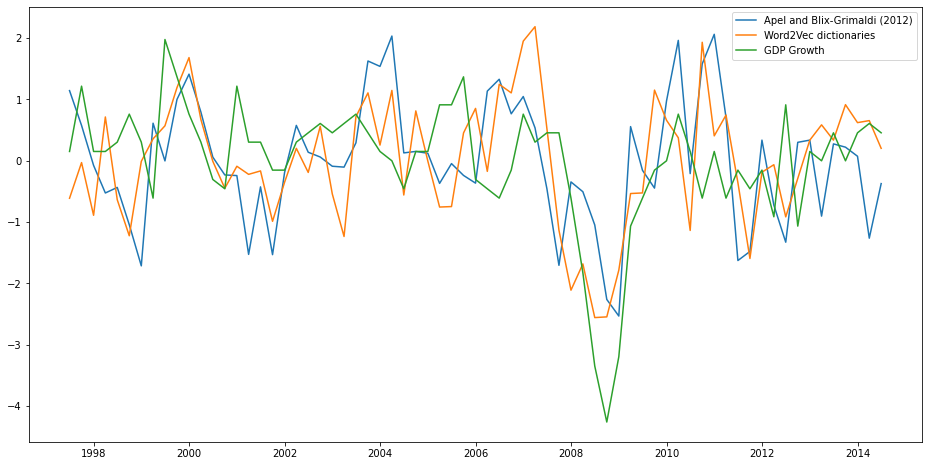

In [55]:
scaler = StandardScaler()

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_AB.values.reshape(-1, 1)), label="Apel and Blix-Grimaldi (2012)")
ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_word2vec.values.reshape(-1, 1)), label="Word2Vec dictionaries")
ax.plot(df["year_quarter"], scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)), label="GDP Growth")

plt.legend()
plt.show()